In [1]:
from warnings import filterwarnings
filterwarnings('ignore')
import os, time
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('SP500_Sheet.csv', 
                 index_col=[0],
                 parse_dates=True)
df.tail()

,Close
Date,
2019-11-14,3096.629883
2019-11-15,3120.459961
2019-11-18,3122.030029
2019-11-19,3120.179932
2019-11-20,3108.459961


In [3]:
df.describe()

,Close
count,4779.000000
mean,1572.439778
std,588.321103
min,676.530029
25%,1142.210022
50%,1337.380005
75%,2001.664978
max,3122.030029


In [4]:
df.isna().sum()

Close    0
dtype: int64

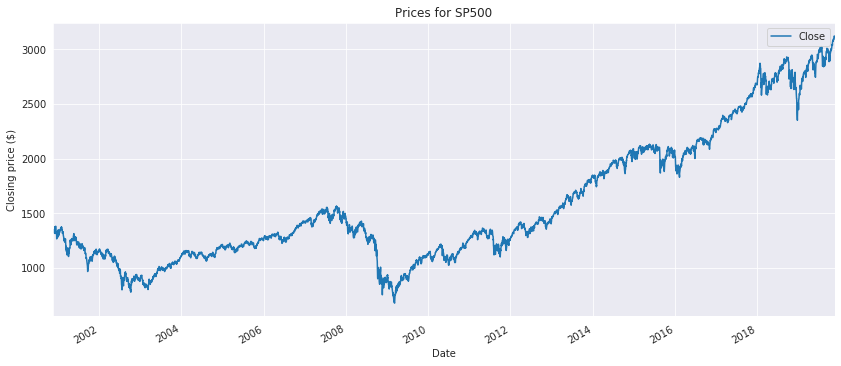

In [5]:
df.plot(figsize=(14, 6))
plt.title('Prices for SP500')
plt.ylabel('Closing price ($)')
plt.legend(loc='best')
plt.show()

In [6]:
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error

lstm_models_folder = 'LSTM_models/'
if not os.path.exists(lstm_models_folder):
    os.mkdir(lstm_models_folder)

# Data Preparation

In [7]:
# Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# split a univariate sequence into samples
def split_sequence(sequence, n_steps, train_size):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    # Train_Test split
    split_X = int(len(X) * train_size)
    split_y = int(len(y) * train_size)
    X_train, y_train = np.array(X[:split_X]), np.array(y[:split_y]),

    split_x_val = int(len(X[int(split_X):]) * 0.5)
    split_y_val = int(len(y[int(split_y):]) * 0.5)
    print(split_x_val, split_y_val)

    X_test, y_test = np.array(X[split_X:(split_X + split_x_val)]), np.array(
        y[split_y:(split_y + split_y_val)])

    X_val, y_val = np.array(X[(split_X + split_x_val):]), np.array(
        y[(split_y + split_y_val):])

    return X_train, X_test, y_train, y_test, X_val, y_val

In [8]:
# define input sequence
raw_seq = list(df['Close'].values)
# choose a number of time steps
n_steps = 7
# split into samples
X_train, X_test, y_train, y_test, X_val, y_val = split_sequence(raw_seq,
                                                                n_steps,
                                                                train_size=0.9)
# summarize the data
print(len(X_train),
      len(X_test),
      len(X_val), 
      len(y_train),
      len(y_test),
      len(y_val)
     )

model_names = {}  # This is to automate forecasts

239 239
4294 239 239 4294 239 239


# Prediction

## 1. Vanilla LSTM

In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))

# define model
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, activation='relu', input_shape=(n_steps, n_features)),
    tf.keras.layers.Dense(1)
])

model_vanilla.compile(optimizer='adam', loss='mape')

print(model_vanilla.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# fit model
history_vanilla = model_vanilla.fit(X_train,
                                    y_train,
                                    epochs=200,
                                    verbose=2,
                                    callbacks=[tf.keras.callbacks.EarlyStopping()],
                                    validation_data=(X_val, y_val))

Train on 4294 samples, validate on 239 samples
Epoch 1/200
4294/4294 - 10s - loss: 8.6839 - val_loss: 1.1871
Epoch 2/200
4294/4294 - 6s - loss: 1.4783 - val_loss: 1.5101


In [11]:
# demonstrate prediction
yhat = model_vanilla.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)

vanilla_name = lstm_models_folder + 'vanilla_lstm-' + f'r2({r2})-mape({mape}).h5'
model_names[r2] = vanilla_name  # For automated forecasts
print(model_names)
model_vanilla.save(vanilla_name)

print(f'r2: {r2} Mape: {mape}')

{0.416: 'LSTM_models/vanilla_lstm-r2(0.416)-mape(3.65).h5'}
r2: 0.416 Mape: 3.65


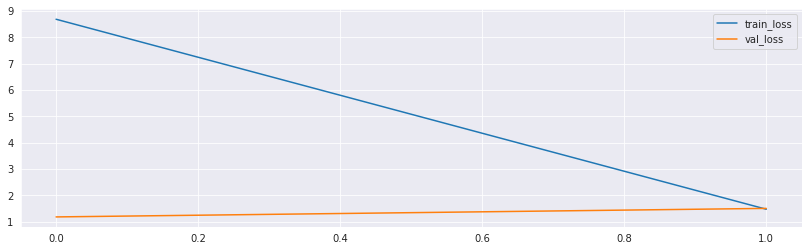

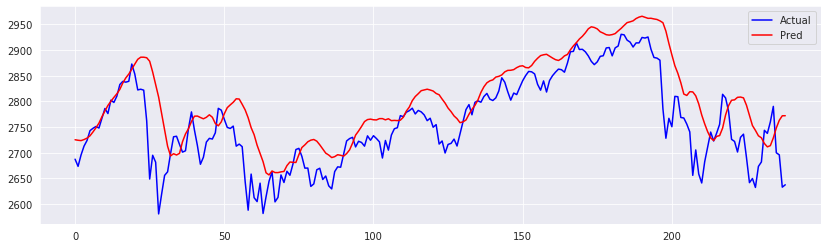

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(history_vanilla.history['loss'], label='train_loss')
plt.plot(history_vanilla.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

## 2. Stacked LSTM

In [13]:
# define model
model_stacked = tf.keras.Sequential([
    tf.keras.layers.LSTM(200, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)),
    tf.keras.layers.LSTM(200, activation='relu'),
    tf.keras.layers.Dense(1)

])
model_stacked.compile(optimizer='adam', loss='mape')
print(model_stacked.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 200)            161600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 482,601
Trainable params: 482,601
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
# fit model
history_stacked = model_stacked.fit(X_train,
                                    y_train,
                                    epochs=200,
                                    verbose=2,
                                    callbacks=[tf.keras.callbacks.EarlyStopping()],
                                    validation_data=(X_val, y_val))

Train on 4294 samples, validate on 239 samples
Epoch 1/200
4294/4294 - 17s - loss: 5.0539 - val_loss: 2.2273
Epoch 2/200
4294/4294 - 13s - loss: 1.7179 - val_loss: 1.8965
Epoch 3/200
4294/4294 - 13s - loss: 1.6972 - val_loss: 1.5418
Epoch 4/200
4294/4294 - 13s - loss: 1.7260 - val_loss: 1.4344
Epoch 5/200
4294/4294 - 13s - loss: 1.7734 - val_loss: 1.2168
Epoch 6/200
4294/4294 - 13s - loss: 1.7493 - val_loss: 1.2527


In [15]:
# demonstrate prediction
yhat = model_stacked.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)
stacked_name = lstm_models_folder + 'stacked_lstm-' + f'r2({r2})-mape({mape}).h5'
model_names[r2] = stacked_name
model_stacked.save(stacked_name)
print(model_names)
print(f'r2: {r2} Mape: {mape}')

{0.416: 'LSTM_models/vanilla_lstm-r2(0.416)-mape(3.65).h5', 0.641: 'LSTM_models/stacked_lstm-r2(0.641)-mape(3.398).h5'}
r2: 0.641 Mape: 3.398


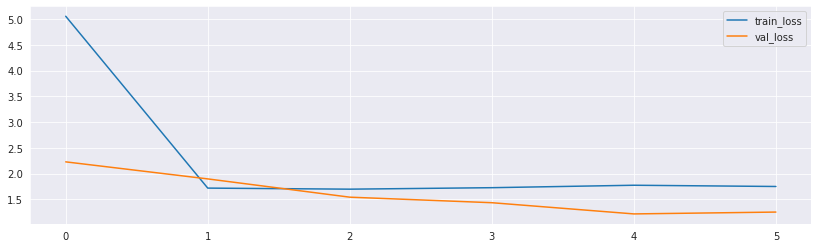

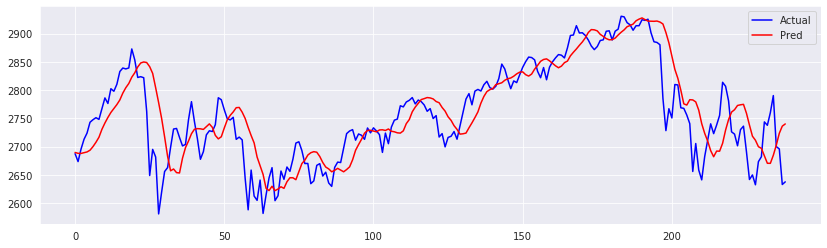

In [16]:
plt.figure(figsize=(14, 4))
plt.plot(history_stacked.history['loss'], label='train_loss')
plt.plot(history_stacked.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

## 3. Bidirectional LSTM

In [17]:
# define model
model_bidirectional = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='relu'),
                                  input_shape=(n_steps, n_features)
                                 ),
    tf.keras.layers.Dense(1)
])

model_bidirectional.compile(optimizer='adam', loss='mape')
print(model_bidirectional.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 512)               528384    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 528,897
Trainable params: 528,897
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# fit model
history_bidirectional = model_bidirectional.fit(X_train,
                                                y_train,
                                                epochs=200,
                                                verbose=2,
                                                callbacks=[tf.keras.callbacks.EarlyStopping()],
                                                validation_data=(X_val, y_val))

Train on 4294 samples, validate on 239 samples
Epoch 1/200
4294/4294 - 17s - loss: 7.6876 - val_loss: 1.8636
Epoch 2/200
4294/4294 - 13s - loss: 1.5138 - val_loss: 1.1966
Epoch 3/200
4294/4294 - 14s - loss: 1.4744 - val_loss: 1.1292
Epoch 4/200
4294/4294 - 15s - loss: 1.6007 - val_loss: 1.2382


In [19]:
# demonstrate prediction
yhat = model_bidirectional.predict(X_test, verbose=0)
r2 = round(r2_score(y_test, yhat), 3)
mape = round(mean_absolute_percentage_error(y_test, yhat), 3)
bidirectional = lstm_models_folder + 'bidirectional_lstm-' + f'r2({r2})-mape({mape}).h5'
model_bidirectional.save(bidirectional)
model_names[r2] = bidirectional
print(model_names)
print(f'r2: {r2} Mape: {mape}')

{0.416: 'LSTM_models/vanilla_lstm-r2(0.416)-mape(3.65).h5', 0.641: 'LSTM_models/stacked_lstm-r2(0.641)-mape(3.398).h5', 0.571: 'LSTM_models/bidirectional_lstm-r2(0.571)-mape(3.536).h5'}
r2: 0.571 Mape: 3.536


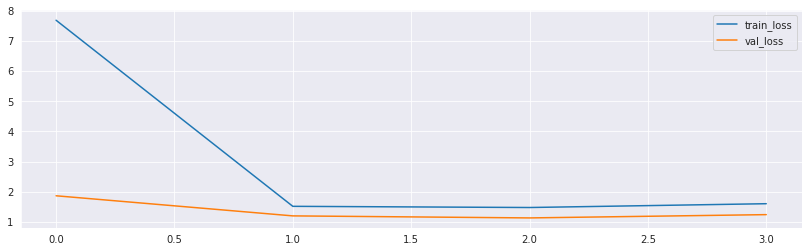

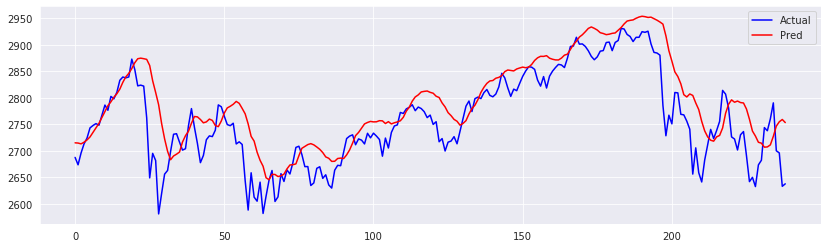

In [20]:
plt.figure(figsize=(14, 4))
plt.plot(history_bidirectional.history['loss'], label='train_loss')
plt.plot(history_bidirectional.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(y_test, color='b', label='Actual')
plt.plot(yhat, color='r', label='Pred')
plt.legend(loc='best')
plt.show()

In [21]:
def get_input_sequesnce(raw_seq):
    # define input sequence
    X, y = list(), list()
    n_steps = 7
    for i in range(len(raw_seq)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(raw_seq) - 1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = raw_seq[i:end_ix], raw_seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)


def predict_prices(model, ref_data, days):
    model = tf.keras.models.load_model(model)
    df_pred = pd.read_csv(ref_data, index_col=[0], parse_dates=True)
    predictions = list()
    
    for i in range(days):
        input_values = df_pred.values[-11:]
        X, y = get_input_sequesnce(input_values)
        X = X.reshape((X.shape[0], X.shape[1], 1))
        df_pred = df_pred.append([{'Close':model.predict(X)[0, 0]}], ignore_index=True)
        predictions.append(model.predict(X)[0, 0])
        
    print(predictions)
    pred = {'Close_predictions': predictions}
    t = pd.to_datetime(df_pred.index[-1])
    indexes = pd.date_range(str(t.year) + '-' + str(t.month) + '-' + str(t.day), periods=days)
    pred = pd.DataFrame(pred, index=indexes)
    pred.to_csv('Predictions.csv')

In [22]:
print(f'Using-> {model_names[max(model_names)]}')
predict_prices(model=model_names[max(model_names)],
               ref_data='SP500_Sheet.csv',
               days=10)

Using-> LSTM_models/stacked_lstm-r2(0.641)-mape(3.398).h5
[3094.0105, 3098.835, 3102.8904, 3106.1614, 3111.2803, 3114.5833, 3117.739, 3120.2224, 3117.098, 3113.5945]
